# Latent topics in Meetup.com events

This project's goal is to perform topic modeling on [Meetup.com](https://www.meetup.com/) event descriptions. 

In the nobebook below, I use a Latent Dirichlet Allocation (LDA) model, which creates a statistical model for discovering the abstract topics that occur in a collection of documents (in this case, Meetup event descriptions). LDA assumes documents represent distributions over latent topics and topics represent distributions over words. The idea here is Meetup event descriptions with similar underylying topics will use similar groups of words.

In [29]:
import re

from bs4 import BeautifulSoup 
import gensim
from gensim.models import LdaModel
from gensim.corpora import Dictionary, MmCorpus
from langdetect import detect
import numpy as np
import pandas as pd
import spacy
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import bokeh.plotting as bp
from bokeh.plotting import save
from bokeh.models import HoverTool

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pyLDAvis.sklearn
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

%config InlineBackend.figure_format = 'retina'

In [41]:
# hides pink warning dialogs... but oddly not all
import warnings
warnings.filterwarnings('ignore')

## Load Data

This is data I collected for a [Data Engineering project](https://github.com/vnessified/meetup_data) in which I stream, structure, store, and analyze event data from Meetup using their [OpenEvent Stream API](https://www.meetup.com/meetup_api/docs/stream/2/open_events/). 

In [34]:
meetup_raw = pd.read_csv('meetup.csv')
meetup_raw.head()

,description,status,event_id,event_name,category
0,<p>FOOD AND FELLOWSHIP | 5 PM</p> \n<p>CONCERT...,upcoming,239660020,We Are Messengers Concert,singles
1,<p><b>【WhyNot!?JAPAN + MeetUp Collaboration Ev...,upcoming,239719229,Friendly Friday!!,socializing
2,<p>TENTATIVE<br></p>\n<p><br></p>\n<p>10.30 - ...,upcoming,239691981,Ansible meetup,tech
3,"<p><span>Hey explorersssss, what's up?</span><...",upcoming,239719250,Secret spot for Hong Kong night view + food ad...,language/ethnic identity
4,"<p>Free, unauditioned, collaborative pop choir...",deleted,gpjktmywhbnb,Come and sing with us!,music


In [35]:
meetup_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195319 entries, 0 to 195318
Data columns (total 5 columns):
description    180184 non-null object
status         195319 non-null object
event_id       195319 non-null object
event_name     195319 non-null object
category       194927 non-null object
dtypes: object(5)
memory usage: 8.9+ MB


## Clean / Munge / EDA

In [36]:
meetup_df = meetup_raw.dropna()

In [37]:
meetup_df.category.value_counts().head(15)

outdoors/adventure          18869
socializing                 18292
tech                        17532
career/business             17144
health/wellbeing            16927
new age/spirituality        10784
sports/recreation            8721
fitness                      8019
language/ethnic identity     7567
food/drink                   5156
games                        5089
fine arts/culture            4140
dancing                      4099
education/learning           3613
music                        3435
Name: category, dtype: int64

### Subset dataframe by top 15 categories

In [38]:
meetup_topcats = meetup_df.groupby('category').filter(lambda x: len(x) >= 3435)
meetup_topcats.reset_index(drop=True, inplace=True)

### Plot top 15 Meetup.com categories by event count

These will serve as the "ground truth" topics for comparison with topics discovered by the LDA model.

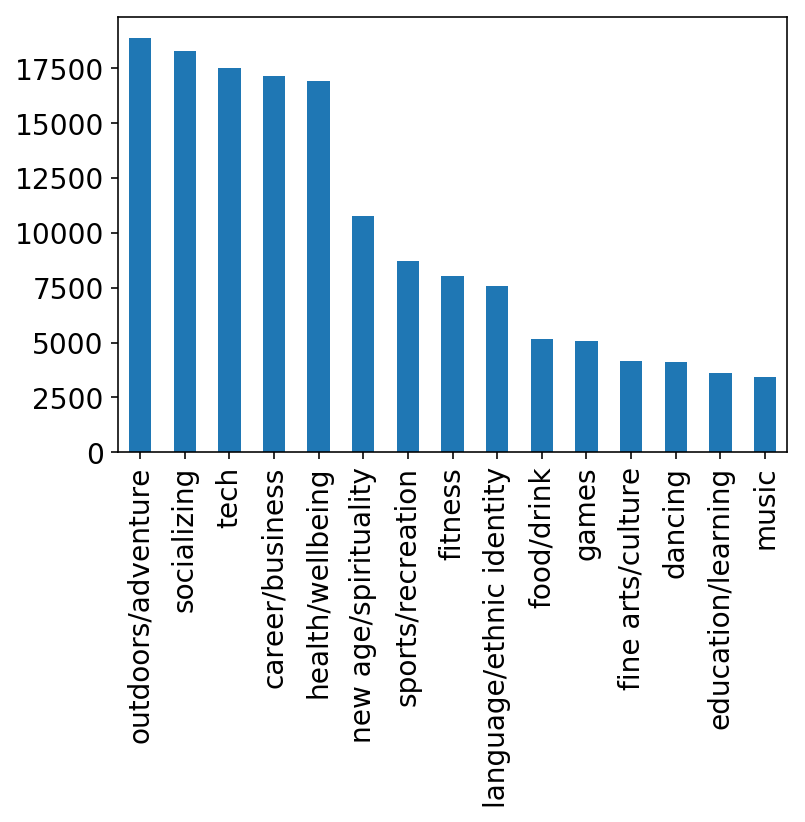

In [39]:
meetup_topcats.category.value_counts().plot.bar(figsize=(6, 4), fontsize=14);

### Examine length of event descriptions

Too short event descriptions are not useful. Too long makes compute slow.

In [42]:
meetup_topcats['desc_len'] = meetup_topcats.description.map(lambda x: len(x))

In [43]:
meetup_topcats.desc_len.describe()

count    149387.000000
mean       1602.312624
std        1975.277755
min           1.000000
25%         467.000000
50%        1000.000000
75%        1969.000000
max       48207.000000
Name: desc_len, dtype: float64

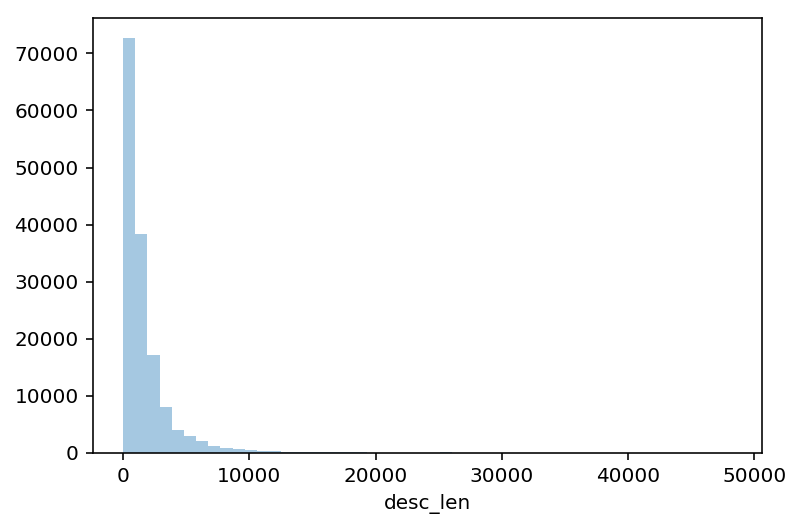

In [45]:
sns.distplot(meetup_topcats.desc_len, kde=False);

#### Check descriptions with only 1 character.

In [46]:
meetup_topcats[meetup_topcats.desc_len == 1].head()

,description,status,event_id,event_name,category,desc_len
1450,\n,upcoming,qxtxgjywhbgc,We're canceling this dawg #3,socializing,1
1635,\n,upcoming,qfncskywhbgc,Futebol de Quarta feira,sports/recreation,1
1814,\n,upcoming,dnbszfywhblc,Free Healing Circle,new age/spirituality,1
2078,\n,upcoming,dpjfhgywhbmb,"More data, more knowledge, become a Quantified...",tech,1
2121,\n,upcoming,dvnvzjywhbmb,Tues. Night Tennis,sports/recreation,1


#### Check descriptions with over 4,000 characters!

In [47]:
meetup_topcats[meetup_topcats.desc_len > 4000].iloc[8]['description'][:1000]

'<p><span>Hi! I am Dai from Team AI.</span><br></p>\n<p>Do you want to level up your data science skills?</p>\n<p>Now Kaggle.com is getting very popular among global data science community.</p>\n<p><a href="https://www.kaggle.com/">https://www.kaggle.com/</a>&nbsp;(Acquired by Google in March 2017) <br></p>\n<p>Kaggle is a competition site for data scientist.</p>\n<p>You can try to use actual financial data, medical data, government data to build a good AI model and compete the score with global community.</p>\n<p>Sounds interesting?&nbsp;</p>\n<p><span>Please just come to our "Team AI Base" in Shibuya and work together.</span> <br></p>\n<p>Are you a beginner? Don\'t worry. We will take care of you.</p>\n<p><span>Let\'s have a fun together in building a good AI.</span></p>\n<p><span>===============================================================</span></p>\n<p><span>こんにちは！ Team AI代表 石井大輔です。</span> <br></p>\n<p>人工知能(AI)は構築するだけではなく、</p>\n<p>生の事例データをINPUT/OUTPUTしてモデルの精度を上げてはじめて価値を生み出しますよね

### Eliminate descriptions over 25 and under 1,000 characters
This is loosely based on the distribution of character counts.

In [48]:
meetup_topcats = meetup_topcats[(meetup_topcats.desc_len > 25) & (meetup_topcats.desc_len < 1000)]

In [49]:
meetup_topcats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73912 entries, 1 to 149386
Data columns (total 6 columns):
description    73912 non-null object
status         73912 non-null object
event_id       73912 non-null object
event_name     73912 non-null object
category       73912 non-null object
desc_len       73912 non-null int64
dtypes: int64(1), object(5)
memory usage: 3.9+ MB


In [50]:
meetup_topcats.desc_len.describe()

count    73912.000000
mean       487.552563
std        270.595791
min         26.000000
25%        259.000000
50%        471.000000
75%        712.000000
max        999.000000
Name: desc_len, dtype: float64

### Remove HTML from event descriptions

First take a random sample from the data as the HTML cleaning and language detection is slow to run. According to my research Parser is faster that BeautifulSoup.

In [79]:
meetup_topcats_samp = meetup_topcats.sample(n=20000)

In [81]:
def text_cleaner(text):
    
    '''Cleans out html tags and other non-letter characters with a 
    regular expression and removes stop words'''
    
    # strip html with BeautifulSoup - get_text gives you the text free of html tags
    no_html = BeautifulSoup(text).get_text() 
  
    # remove extra junk
    clean = re.sub("[^a-zA-Z]", " ", no_html) 

    return " ".join(clean.split())

In [82]:
meetup_topcats_samp['description'] = meetup_topcats['description'].map(text_cleaner)

In [83]:
meetup_topcats_samp.reset_index(drop=True, inplace=True)

### Detect event description language
The data includes descriptions from Meetup events from all over the world. As such there are non-english languages represented in the dataset. These need to be removed from the data before topic modeling so that the results are interpretable. Also note: TextBlob's `.detect_language()` method is incredibly slow — I switched to the langdetect package from Google and it's still slow but faster. Below is a demo of langdetect's `detect` function.

In [88]:
meetup_topcats_samp['description'].iloc[5]

'La premi re partie sera d di e la pratique des diff rentes techniques n cessaires pour comprendre comment mettre les harmoniques avec l aide d un spectrogramme permettant de voir ces sons subtils difficilement perceptibles pour les d butants La seconde partie sera d di e aux ressentis et effets nerg tiques per us lors de la r ception du Chant Diphonique accompagn par une Shruti Box dans diff rentes positions de face de dos et de chaque c t du corps'

In [89]:
detect(meetup_topcats_samp['description'].iloc[5])

'fr'

### Eliminate empty descriptions 
After removing the HTML, some description's length is zero — this throws an error in language detection, additionally these provide literally zero information.

In [90]:
meetup_topcats_samp['clean_desc_len'] = meetup_topcats_samp['description'].map(lambda x: len(x))

In [92]:
meetup_topcats_samp.clean_desc_len.describe()

count    20000.000000
mean       378.623650
std        225.093908
min          0.000000
25%        193.000000
50%        362.000000
75%        553.000000
max        960.000000
Name: clean_desc_len, dtype: float64

In [93]:
meetup_topcats_samp = meetup_topcats_samp[meetup_topcats_samp.clean_desc_len > 20]

In [94]:
meetup_topcats_samp['lang'] = meetup_topcats_samp['description'].map(lambda x: detect(x[:100]))

### Top languages by event description

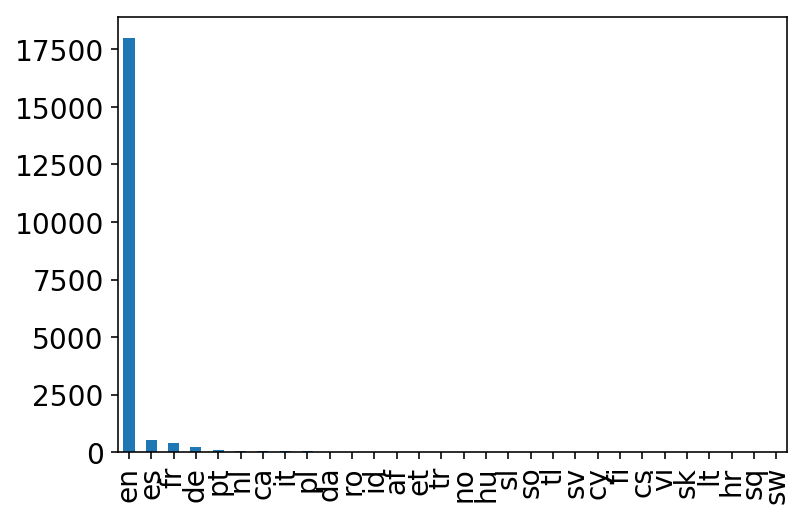

In [100]:
meetup_topcats_samp.lang.value_counts().plot.bar(figsize=(6, 4), fontsize=14);

In [101]:
len(meetup_topcats_samp.lang.value_counts())

30

In [102]:
meetup_en = meetup_topcats_samp[meetup_topcats_samp.lang == 'en']

In [103]:
meetup_en.lang.value_counts()

en    18000
Name: lang, dtype: int64

#### Save dataframe to csv as the above is a time consuming process

In [96]:
meetup_topcats_samp.to_csv('clean_data.csv')

## Vectorize text

Use term frequency-inverse document frequency (`TfidfVectorizer`). `TfidfVectorizer` is favorably over `CountVectorizer` because it takes it counts the number of times a word appears in a given description, but then offsets by the frequency of the word in the corpus, which helps to account for the fact that some words appear more frequently.

In [7]:
meetup_topcats_samp = pd.read_csv('clean_data.csv')

In [9]:
tf_vectorizer = TfidfVectorizer(analyzer = "word", stop_words='english', max_features = 1000)
vectorized = tf_vectorizer.fit_transform(meetup_topcats_samp.description)
vectorized.shape

(19558, 1000)

In [10]:
vectorized.A

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

#### `TfidfVectorizer`  only considers the top 1000 features/words by frequency 

In [11]:
vocab = tf_vectorizer.get_feature_names()
len(vocab)

1000

In [12]:
len(tf_vectorizer.vocabulary_)

1000

In [13]:
pd.DataFrame(vectorized.A, columns=sorted(tf_vectorizer.vocabulary_.keys(), key=lambda k: tf_vectorizer.vocabulary_[k])).head()

,able,accepted,access,action,active,activities,activity,add,additional,address,...,workshops,world,www,year,years,yes,yoga,youtu,youtube,zu
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.072445,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Fit LDA model (scikit-learn)

In LDA an important hyperparameter is K (`n_topics`), the number of topics. For this experiment I've set the number of topics to 15 (same of the "ground truth" topics selected above from Meetup categories).

In the resulting matrix, each row is a probability distribution (learned by the LDA model) of this meetup event belonging to a certain topic (for example X_topics[0][0] represents the probablitiy of the first description belong to topic 1).

In [15]:
lda_model = LatentDirichletAllocation(n_components=15, random_state=0)
X_topics = lda_model.fit_transform(vectorized)

/Users/VanessaG/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:532: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [16]:
X_topics.shape

(19558, 15)

In [17]:
X_topics

array([[ 0.01549528,  0.01549532,  0.14864357, ...,  0.01549532,
         0.01549528,  0.01549529],
       [ 0.01031572,  0.62587572,  0.20522575, ...,  0.01031573,
         0.01031573,  0.01031573],
       [ 0.01350419,  0.13618425,  0.01350434, ...,  0.01350421,
         0.01350419,  0.01350421],
       ..., 
       [ 0.34679712,  0.17872744,  0.02118792, ...,  0.02118811,
         0.02118792,  0.02118792],
       [ 0.12248533,  0.36714139,  0.01144556, ...,  0.01144552,
         0.01144549,  0.01144555],
       [ 0.01196   ,  0.01196004,  0.01196001, ...,  0.01196002,
         0.01196   ,  0.20646301]])

In [18]:
X_topics[0]

array([ 0.01549528,  0.01549532,  0.14864357,  0.01549528,  0.01549528,
        0.01549532,  0.01549528,  0.64991757,  0.01549529,  0.01549531,
        0.01549531,  0.01549529,  0.01549532,  0.01549528,  0.01549529])

In [19]:
X_topics[0][0]

0.015495282887134879

### Cast results into a dataframe

In [20]:
word_dict = {}
for topic_idx, topic in enumerate(lda_model.components_):
    word_dict[topic_idx] = [tf_vectorizer.get_feature_names()[i] for i in topic.argsort()[:-10 - 1:-1]]

pd.DataFrame(word_dict).T

,0,1,2,3,4,5,6,7,8,9
0,estate,real,financial,net,books,money,programming,singing,shop,investors
1,meetup,meeting,group,time,meet,ll,people,know,come,let
2,ride,miles,hike,trail,walk,park,mile,parking,lake,pace
3,et,le,pour,les,la,vous,en,du,des,nous
4,en,la,el,para,que,los,las,del,es,una
5,pm,park,meet,parking,court,walk,play,bring,sunday,comedy
6,concert,downtown,band,opening,venue,pop,gym,volleyball,admission,prepared
7,come,food,bring,great,free,pm,music,join,wine,night
8,workout,fitness,training,weight,hill,mountain,exercise,cardio,rock,camp
9,class,yoga,meditation,learn,classes,dance,body,practice,join,free


### Visualize the model with pyLDAvis

pyLDAvis is an interactive visualization tool built on d3 ported from R to help understand topic modeling.

The `mds` argument of the `.prepare` method takes a function that takes a topic_term_dists as an input and outputs a n_topics by 2 distance matrix. The output approximates the distance between topics. Below I try pcoa = principle component analysis, mmds = multidimensional scaling, and tsne = t-distributed stochastic neighbor embedding.

In [21]:
pyLDAvis.sklearn.prepare(lda_model, vectorized, tf_vectorizer, mds='pcoa')

/Users/VanessaG/anaconda3/envs/nlp/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
9      19.545443        1       1 -0.138362  0.011749
1      17.290928        1       2 -0.152044  0.060558
5      12.118502        1       3 -0.163066  0.114571
7      11.830034        1       4 -0.184350  0.081474
10      6.574375        1       5 -0.112415 -0.015557
11      5.420728        1       6  0.054988  0.120652
2       4.806439        1       7 -0.083928  0.098816
12      4.127348        1       8 -0.140801  0.017707
14      3.642053        1       9 -0.019202 -0.116779
4       3.282493        1      10  0.360501  0.154655
8       2.879920        1      11 -0.020538 -0.080385
3       2.773486        1      12  0.328056  0.125248
13      2.097355        1      13  0.180578 -0.201392
0       2.017214        1      14  0.050775 -0.241441
6       1.593682        1      15  0.039808 -0.129877, topic_info=     Category        Freq           Term       Total  loglift  logprob
term                                                                  
443   Default  302.000000             la  302.000000  30.0000  30.0000
144   Default  442.000000            com  442.000000  29.0000  29.0000
241   Default  281.000000             en  281.000000  28.0000  28.0000
992   Default  390.000000            www  390.000000  27.0000  27.0000
51    Default  177.000000           band  177.000000  26.0000  26.0000
157   Default  166.000000        concert  166.000000  25.0000  25.0000
396   Default  313.000000          https  313.000000  24.0000  24.0000
224   Default  160.000000       downtown  160.000000  23.0000  23.0000
647   Default  277.000000           play  277.000000  22.0000  22.0000
319   Default  249.000000           game  249.000000  21.0000  21.0000
928   Default  155.000000            und  155.000000  20.0000  20.0000
320   Default  216.000000          games  216.000000  19.0000  19.0000
987   Default  164.000000        workout  164.000000  18.0000  18.0000
239   Default  168.000000             el  168.000000  17.0000  17.0000
90    Default  226.000000       business  226.000000  16.0000  16.0000
259   Default  152.000000             et  152.000000  15.0000  15.0000
618   Default  158.000000           para  158.000000  14.0000  14.0000
293   Default  156.000000        fitness  156.000000  13.0000  13.0000
731   Default  185.000000           ride  185.000000  12.0000  12.0000
944   Default  160.000000          venue  160.000000  11.0000  11.0000
395   Default  275.000000           http  275.000000  10.0000  10.0000
697   Default  158.000000            que  158.000000   9.0000   9.0000
709   Default  130.000000           real  130.000000   8.0000   8.0000
133   Default  387.000000          class  387.000000   7.0000   7.0000
916   Default  141.000000       training  141.000000   6.0000   6.0000
275   Default  164.000000       facebook  164.000000   5.0000   5.0000
599   Default  102.000000        opening  102.000000   4.0000   4.0000
453   Default  115.000000             le  115.000000   3.0000   3.0000
535   Default  132.000000          miles  132.000000   2.0000   2.0000
896   Default  154.000000        tickets  154.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
517   Topic15    0.275259          means   26.714912  -0.4361  -8.3616
112   Topic15    0.275257      certified   26.742199  -0.4372  -8.3617
272   Topic15    0.275257        experts   26.771806  -0.4383  -8.3617
547   Topic15    0.275257         mobile   26.788400  -0.4389  -8.3617
299   Topic15    0.275257        focused   26.909322  -0.4434  -8.3617
374   Topic15    0.275257          helps   26.912855  -0.4435  -8.3617
152   Topic15    0.275257  communication   27.197783  -0.4541  -8.3617
1     Topic15    0.275258       accepted   27.350139  -0.4596  -8.3616
759   Topic15    0.275257        seating   27.607013  -0.4690  -8.3617
76    Topic15    0.275260        booking   27.749667  -0.

In [22]:
pyLDAvis.sklearn.prepare(lda_model, vectorized, tf_vectorizer, mds='mmds')

/Users/VanessaG/anaconda3/envs/nlp/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
9      19.545443        1       1 -0.024693 -0.052190
1      17.290928        1       2  0.096544 -0.092189
5      12.118502        1       3  0.121151  0.089255
7      11.830034        1       4  0.183085 -0.034890
10      6.574375        1       5  0.284065 -0.214795
11      5.420728        1       6  0.433692  0.026929
2       4.806439        1       7  0.286430  0.259803
12      4.127348        1       8  0.152931 -0.347776
14      3.642053        1       9 -0.233054 -0.127599
4       3.282493        1      10 -0.441456 -0.227624
8       2.879920        1      11 -0.272050  0.274693
3       2.773486        1      12 -0.455992  0.079407
13      2.097355        1      13  0.067830  0.472131
0       2.017214        1      14 -0.104310 -0.418782
6       1.593682        1      15 -0.094174  0.313627, topic_info=     Category        Freq           Term       Total  loglift  logprob
term                                                                  
443   Default  302.000000             la  302.000000  30.0000  30.0000
144   Default  442.000000            com  442.000000  29.0000  29.0000
241   Default  281.000000             en  281.000000  28.0000  28.0000
992   Default  390.000000            www  390.000000  27.0000  27.0000
51    Default  177.000000           band  177.000000  26.0000  26.0000
157   Default  166.000000        concert  166.000000  25.0000  25.0000
396   Default  313.000000          https  313.000000  24.0000  24.0000
224   Default  160.000000       downtown  160.000000  23.0000  23.0000
647   Default  277.000000           play  277.000000  22.0000  22.0000
319   Default  249.000000           game  249.000000  21.0000  21.0000
928   Default  155.000000            und  155.000000  20.0000  20.0000
320   Default  216.000000          games  216.000000  19.0000  19.0000
987   Default  164.000000        workout  164.000000  18.0000  18.0000
239   Default  168.000000             el  168.000000  17.0000  17.0000
90    Default  226.000000       business  226.000000  16.0000  16.0000
259   Default  152.000000             et  152.000000  15.0000  15.0000
618   Default  158.000000           para  158.000000  14.0000  14.0000
293   Default  156.000000        fitness  156.000000  13.0000  13.0000
731   Default  185.000000           ride  185.000000  12.0000  12.0000
944   Default  160.000000          venue  160.000000  11.0000  11.0000
395   Default  275.000000           http  275.000000  10.0000  10.0000
697   Default  158.000000            que  158.000000   9.0000   9.0000
709   Default  130.000000           real  130.000000   8.0000   8.0000
133   Default  387.000000          class  387.000000   7.0000   7.0000
916   Default  141.000000       training  141.000000   6.0000   6.0000
275   Default  164.000000       facebook  164.000000   5.0000   5.0000
599   Default  102.000000        opening  102.000000   4.0000   4.0000
453   Default  115.000000             le  115.000000   3.0000   3.0000
535   Default  132.000000          miles  132.000000   2.0000   2.0000
896   Default  154.000000        tickets  154.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
517   Topic15    0.275259          means   26.714912  -0.4361  -8.3616
112   Topic15    0.275257      certified   26.742199  -0.4372  -8.3617
272   Topic15    0.275257        experts   26.771806  -0.4383  -8.3617
547   Topic15    0.275257         mobile   26.788400  -0.4389  -8.3617
299   Topic15    0.275257        focused   26.909322  -0.4434  -8.3617
374   Topic15    0.275257          helps   26.912855  -0.4435  -8.3617
152   Topic15    0.275257  communication   27.197783  -0.4541  -8.3617
1     Topic15    0.275258       accepted   27.350139  -0.4596  -8.3616
759   Topic15    0.275257        seating   27.607013  -0.4690  -8.3617
76    Topic15    0.275260        booking   27.749667  -0.

In [23]:
pyLDAvis.sklearn.prepare(lda_model, vectorized, tf_vectorizer, mds='tsne')

/Users/VanessaG/anaconda3/envs/nlp/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
9      19.545443        1       1   31.193888  147.556931
1      17.290928        1       2  -59.261768 -116.834526
5      12.118502        1       3   33.538330 -129.493317
7      11.830034        1       4  -72.279182   45.521835
10      6.574375        1       5 -143.624557   -8.541894
11      5.420728        1       6  -17.317989    4.896492
2       4.806439        1       7   90.752853   85.824776
12      4.127348        1       8    7.255022   72.646072
14      3.642053        1       9   93.279480  -64.478958
4       3.282493        1      10  134.426514   12.156272
8       2.879920        1      11  -75.675621  -42.274021
3       2.773486        1      12   55.022671    9.095498
13      2.097355        1      13  -54.751225  129.162460
0       2.017214        1      14    8.525807  -58.685760
6       1.593682        1      15 -135.217621   87.098068, topic_info=     Category        Freq           Term       Total  loglift  logprob
term                                                                  
443   Default  302.000000             la  302.000000  30.0000  30.0000
144   Default  442.000000            com  442.000000  29.0000  29.0000
241   Default  281.000000             en  281.000000  28.0000  28.0000
992   Default  390.000000            www  390.000000  27.0000  27.0000
51    Default  177.000000           band  177.000000  26.0000  26.0000
157   Default  166.000000        concert  166.000000  25.0000  25.0000
396   Default  313.000000          https  313.000000  24.0000  24.0000
224   Default  160.000000       downtown  160.000000  23.0000  23.0000
647   Default  277.000000           play  277.000000  22.0000  22.0000
319   Default  249.000000           game  249.000000  21.0000  21.0000
928   Default  155.000000            und  155.000000  20.0000  20.0000
320   Default  216.000000          games  216.000000  19.0000  19.0000
987   Default  164.000000        workout  164.000000  18.0000  18.0000
239   Default  168.000000             el  168.000000  17.0000  17.0000
90    Default  226.000000       business  226.000000  16.0000  16.0000
259   Default  152.000000             et  152.000000  15.0000  15.0000
618   Default  158.000000           para  158.000000  14.0000  14.0000
293   Default  156.000000        fitness  156.000000  13.0000  13.0000
731   Default  185.000000           ride  185.000000  12.0000  12.0000
944   Default  160.000000          venue  160.000000  11.0000  11.0000
395   Default  275.000000           http  275.000000  10.0000  10.0000
697   Default  158.000000            que  158.000000   9.0000   9.0000
709   Default  130.000000           real  130.000000   8.0000   8.0000
133   Default  387.000000          class  387.000000   7.0000   7.0000
916   Default  141.000000       training  141.000000   6.0000   6.0000
275   Default  164.000000       facebook  164.000000   5.0000   5.0000
599   Default  102.000000        opening  102.000000   4.0000   4.0000
453   Default  115.000000             le  115.000000   3.0000   3.0000
535   Default  132.000000          miles  132.000000   2.0000   2.0000
896   Default  154.000000        tickets  154.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
517   Topic15    0.275259          means   26.714912  -0.4361  -8.3616
112   Topic15    0.275257      certified   26.742199  -0.4372  -8.3617
272   Topic15    0.275257        experts   26.771806  -0.4383  -8.3617
547   Topic15    0.275257         mobile   26.788400  -0.4389  -8.3617
299   Topic15    0.275257        focused   26.909322  -0.4434  -8.3617
374   Topic15    0.275257          helps   26.912855  -0.4435  -8.3617
152   Topic15    0.275257  communication   27.197783  -0.4541  -8.3617
1     Topic15    0.275258       accepted   27.350139  -0.4596  -8.3616
759   Topic15    0.275257        seating   27.607013  -0.469

## Fit LDA model (gensim)

### Preprocess with Spacy

In [24]:
spc = spacy.load('en')

# parser and named entity recognizer — noun, verb, adjective, adverb, proper noun
keep_pos = set([90, 98, 82, 84, 94])
pipe = spc.pipe(meetup_topcats_samp.description, parse=False, entity=False)

processed = [[token.lemma_ for token in document if token.pos in keep_pos] for document in pipe]

vocabulary = Dictionary(processed)
vocabulary.filter_extremes(no_below=3, no_above=0.5)

meetup_corpus = [vocabulary.doc2bow(doc) for doc in processed]

###  `num_topics` = 15

In [25]:
gensim_lda_model = LdaModel(corpus=meetup_corpus, id2word=vocabulary, num_topics=15, chunksize=1500, iterations=200, alpha='auto')

vis = pyLDAvis.gensim.prepare(gensim_lda_model, meetup_corpus, vocabulary, mds='pcoa')
pyLDAvis.display(vis)

/Users/VanessaG/anaconda3/envs/nlp/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


###  `num_topics` = 30

In [26]:
gensim_lda_model2 = LdaModel(corpus=meetup_corpus, id2word=vocabulary, num_topics=30, chunksize=1500, iterations=200, alpha='auto')

vis = pyLDAvis.gensim.prepare(gensim_lda_model2, meetup_corpus, vocabulary, mds='pcoa')
pyLDAvis.display(vis)

/Users/VanessaG/anaconda3/envs/nlp/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


###  `num_topics` = 5

In [27]:
gensim_lda_model3 = LdaModel(corpus=meetup_corpus, id2word=vocabulary, num_topics=5, chunksize=1500, iterations=200, alpha='auto')

vis = pyLDAvis.gensim.prepare(gensim_lda_model3, meetup_corpus, vocabulary, mds='pcoa')
pyLDAvis.display(vis)

/Users/VanessaG/anaconda3/envs/nlp/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
